# Iurii Fedotov: Power Forecast Challenge
## Approach
My approach to predicting hourly power consumption for the test dataset is illustrated in the chart below.

1. Predict daily average consumption per 1 customer. Model: CatBoostRegressor. Features:
   - Mean temperature in that day
   - Daylight length in that day
   - Growth in number of customers in that day versus 2 weeks ago
1. Multiply this daily average consumption per 1 customer by the number of customers (given in assignment), and thus predict the total daily consumption
1. For each day, distribute the predicted daily consumption by 24 hours using the distributions from the previous year.

![My schema for solving this problem](./schema.png)

This notebook is divided into sections which correspond to these steps (1-3).

### Step 0. Import packages, data, and preprocess original data

In [1]:
# Import packages
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%config InlineBackend.figure_format = 'retina' # Make matplotlib render retina-quality charts
splitline = '-' * 100 # I will use this line to make printing outputs nicer

# Import consumptions - the main train file. No modifications here so far.
consumptions = pd.read_csv("./Consumptions.csv", sep = ';', parse_dates = ['Date'])

# Import both temperatures files
temperatures = pd.read_csv("./Temperatures.csv", sep = ';', parse_dates = ['Date'])
temperatures2 = pd.read_csv("./Temperatures2.csv", sep = ';', parse_dates = ['Date'])
# Concatenate them, since they provide similar data for 2 consecutive periods, and leave tMean column only
temperatures = pd.concat([temperatures, temperatures2], axis = 0).reset_index(drop = True)
temperatures.drop(['tMax', 'tMin'], axis = 1, inplace = True)

# Import the file with number of customers (onwards - nCUPS) for the test period
ncustomers = pd.read_csv("./nCustomers.csv", sep = ';',
                         parse_dates = ['datetime']).rename(columns = {'datetime':'Date'})

# Calculate nCUPS for each day of the train set
old_ncups_series = consumptions.groupby('Date').CUPS.nunique()
# Put it to the dataframe of the same format as 'ncustomers'
old_ncups = pd.DataFrame()
old_ncups['Date'] = old_ncups_series.index.tolist()
old_ncups['nCUPS'] = old_ncups_series.values.tolist()
# Concatenate 2 dataframes to get a single dataframe of nCUPS. Similar to what we did with temperature.
ncustomers = pd.concat([old_ncups, ncustomers], axis = 0).reset_index(drop = True)
# Drop duplicates, because the 'ncustomers' file contains some rows for train part
ncustomers = ncustomers.drop_duplicates().reset_index(drop = True)
# Create a column of nCUPS shifted by 2 weeks backwards
ncustomers['nCUPS2wago'] = ncustomers['nCUPS'].shift(14)
# Fill in the NaN values (first 14 days)
ncustomers['nCUPS2wago_est'] = ncustomers.nCUPS * np.mean(ncustomers.nCUPS2wago / ncustomers.nCUPS)
ncustomers.nCUPS2wago = ncustomers.nCUPS2wago.fillna(value = ncustomers.nCUPS2wago_est)
ncustomers.drop(['nCUPS2wago_est'], axis = 1, inplace = True)
# Create a new feature - growth in nCUPS in the past 2 weeks
ncustomers['growth'] = (ncustomers.nCUPS / ncustomers.nCUPS2wago) - 1

# Import an excel file with sunlight data. Source: https://www.timeanddate.com/sun/
sun_data = pd.read_excel("./Sun hours per day.xlsx",
                         usecols = ['Date', 'Length'],
                         parse_dates = ['Date'])
# Convert length of the sun-shining period to proper float format
sun_data['Length'] = sun_data['Length'].astype(str)
sun_data['Length'] = sun_data['Length'].str.split(':').str[0].astype(int) \
                     + sun_data['Length'].str.split(':').str[1].astype(int) / 60

# Display heads of all DFs that we imported and preprocessed
print('Consumptions:')
display(consumptions.head())
print(splitline)
print('Temperatures:')
display(temperatures.head())
print(splitline)
print('Number of customers:')
display(ncustomers.head())
print(splitline)
print('Length of the sunny part of the day:')
display(sun_data.head())

Consumptions:


,CUPS,ZipCode,Rate,Date,Hour,Value
0,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,1,502
1,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,2,418
2,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,3,418
3,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,4,418
4,F0216555032235ABF9A1515F221C3F7F,11403,2.0A,2016-06-01,5,418


----------------------------------------------------------------------------------------------------
Temperatures:


,Date,tMean
0,2016-06-01,17.566260
1,2016-06-02,18.682520
2,2016-06-03,19.655422
3,2016-06-04,19.028745
4,2016-06-05,19.553846


----------------------------------------------------------------------------------------------------
Number of customers:


,Date,nCUPS,nCUPS2wago,growth
0,2016-06-01,124,111.286542,0.114241
1,2016-06-02,126,113.081486,0.114241
2,2016-06-03,128,114.876430,0.114241
3,2016-06-04,129,115.773902,0.114241
4,2016-06-05,128,114.876430,0.114241


----------------------------------------------------------------------------------------------------
Length of the sunny part of the day:


,Date,Length
0,2016-06-01,14.016667
1,2016-06-02,14.033333
2,2016-06-03,14.033333
3,2016-06-04,14.050000
4,2016-06-05,14.066667


### Step 1.1. Calculate average daily consumption per 1 client for each day of the train period

In [2]:
# Create a dataframe with total daily consumption for each day of the train period
train = consumptions[['Date', 'Value']].groupby(['Date'], \
        as_index=False).sum().sort_values(by=['Date'], ascending=True).rename(columns = {'Value':'dailyConsumption'})

# Merge it with 3 other datasets that we have
train = train.merge(ncustomers, on = 'Date', how = 'left')
train = train.merge(temperatures, on = 'Date', how = 'left')
train = train.merge(sun_data, on = 'Date', how = 'left')

# Calculate average daily consumption per client
train['AvgConsPerClient'] = train['dailyConsumption'] / train['nCUPS']

display(train.head())

,Date,dailyConsumption,nCUPS,nCUPS2wago,growth,tMean,Length,AvgConsPerClient
0,2016-06-01,1344028,124,111.286542,0.114241,17.566260,14.016667,10838.935484
1,2016-06-02,1377470,126,113.081486,0.114241,18.682520,14.033333,10932.301587
2,2016-06-03,1413164,128,114.876430,0.114241,19.655422,14.033333,11040.343750
3,2016-06-04,1306564,129,115.773902,0.114241,19.028745,14.050000,10128.403101
4,2016-06-05,1188794,128,114.876430,0.114241,19.553846,14.066667,9287.453125


### Step 1.2. Create a model for average daily consumption per client

Best GridSearch params {'l2_leaf_reg': 20}
Average CV MAE for CBR:  868


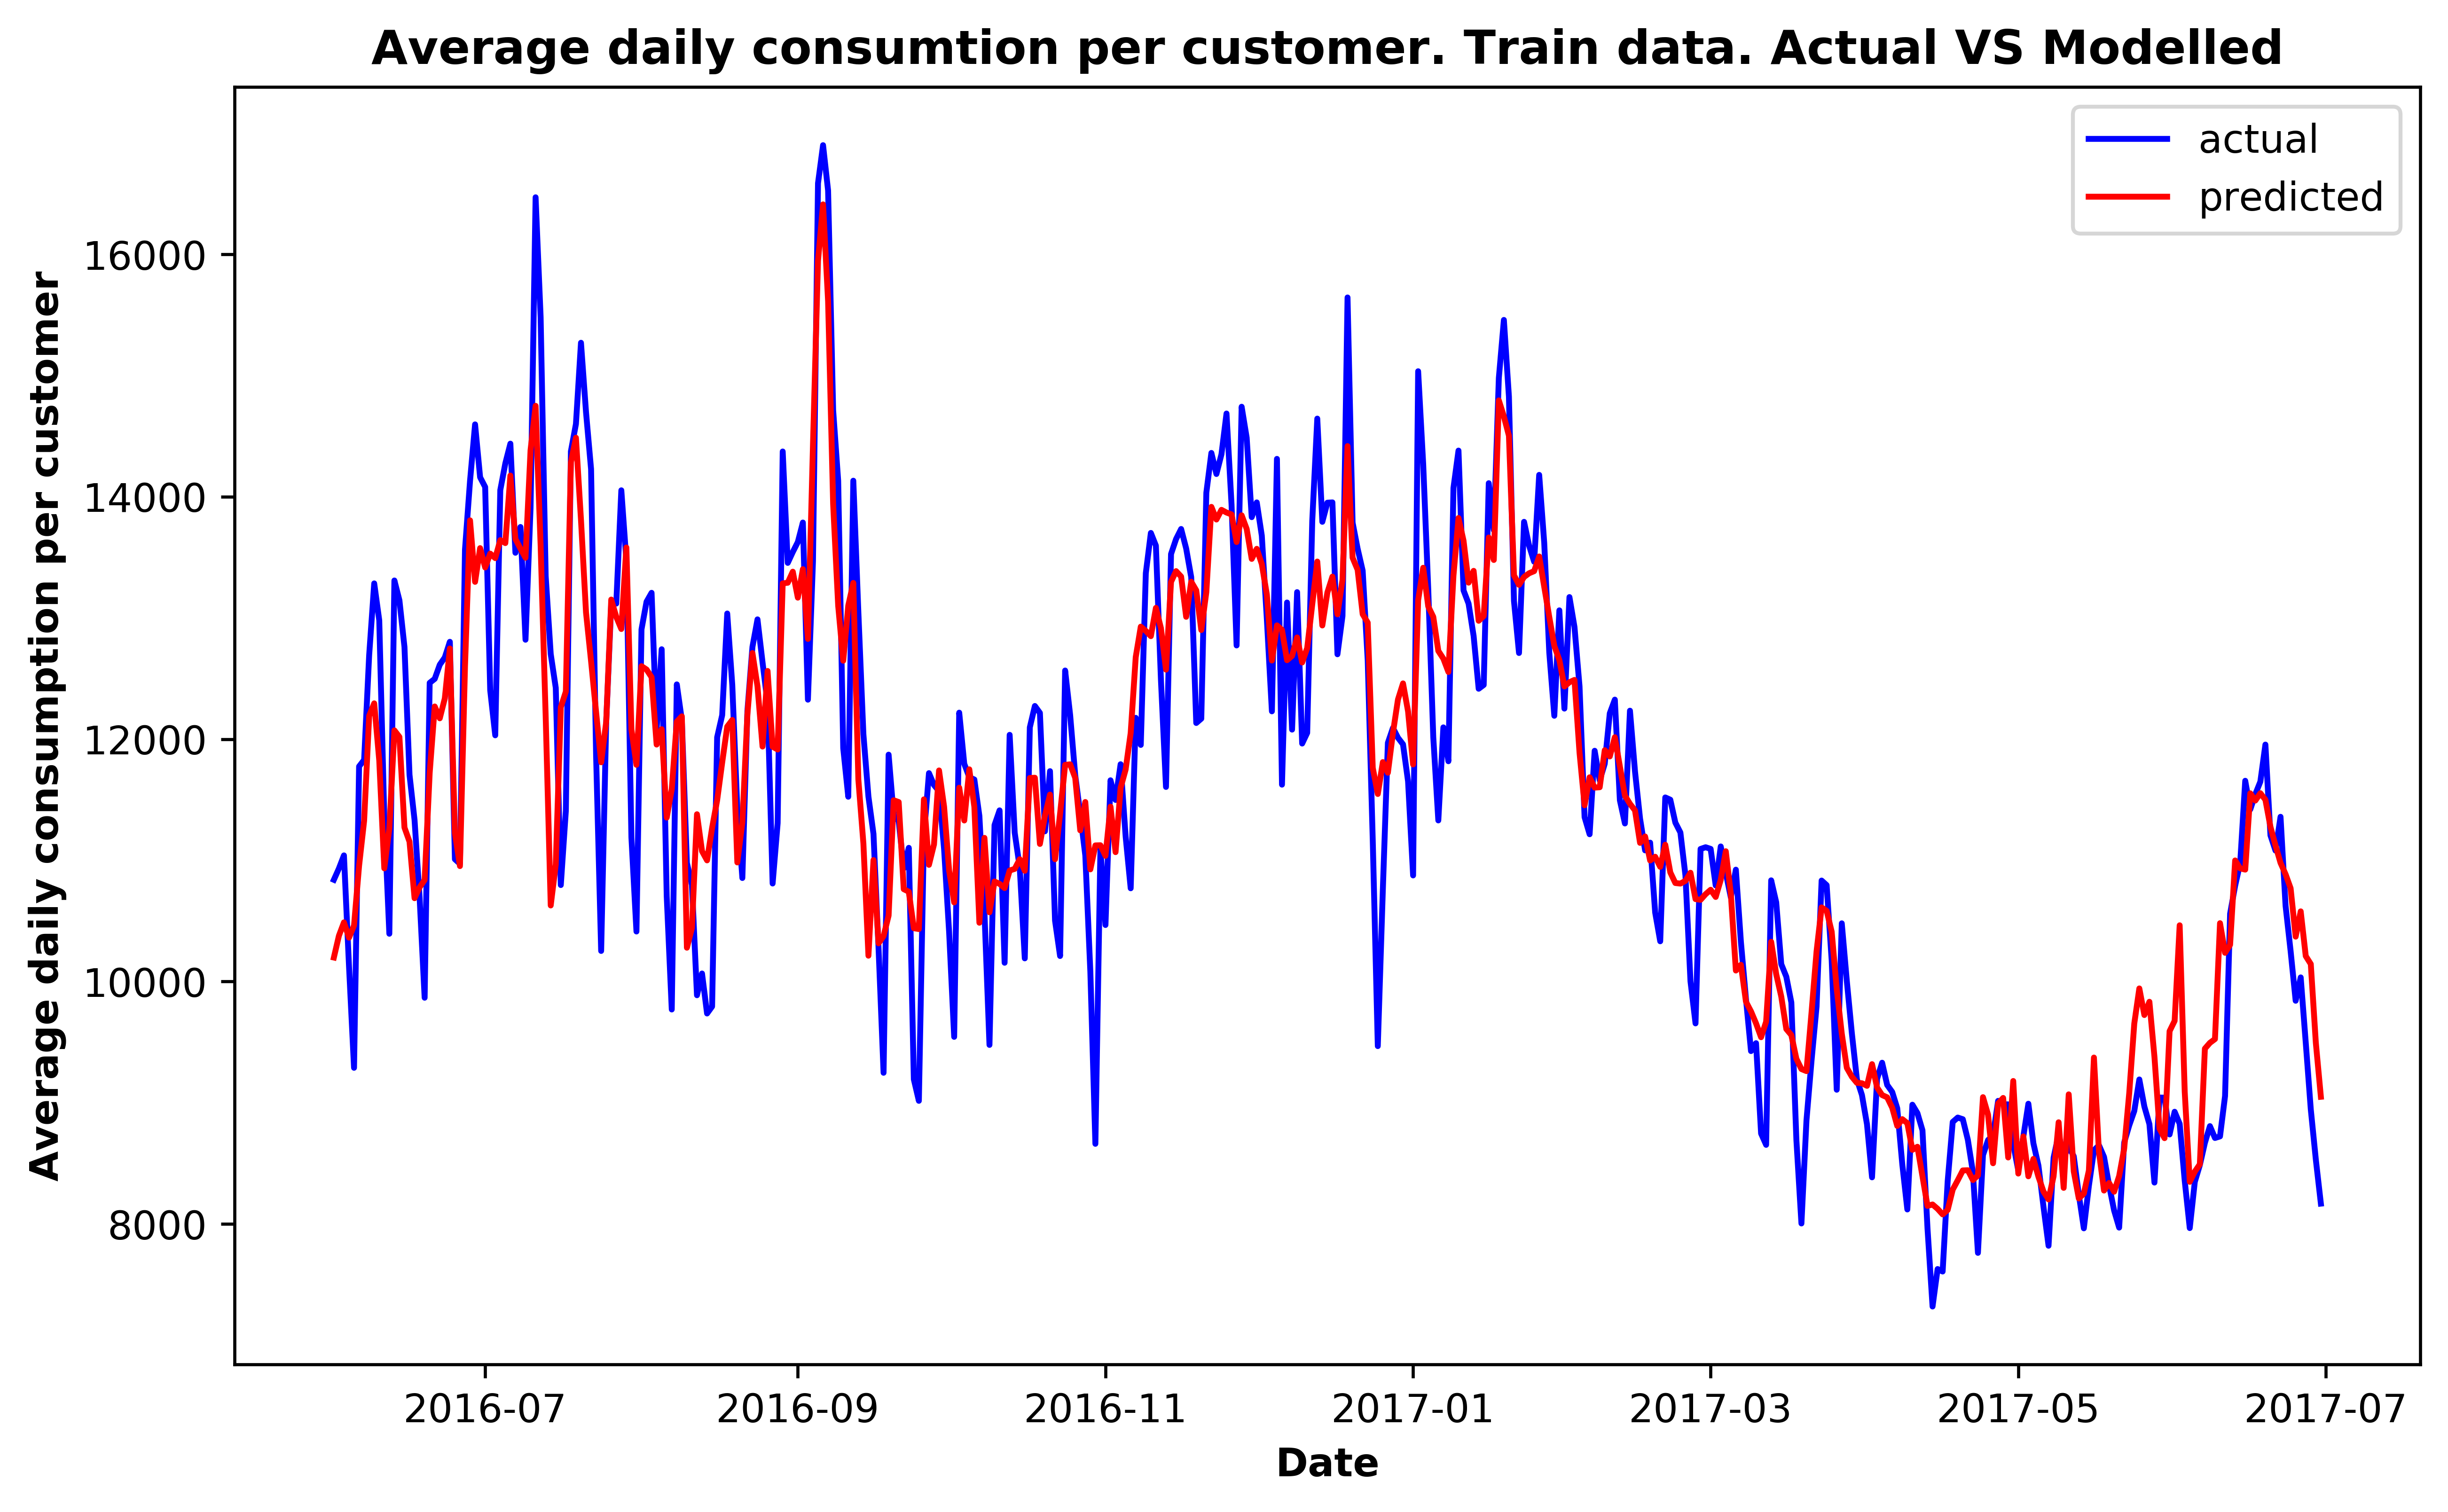

In [3]:
# Prepare X(features) and y(target) for validating and training 
X = train[['tMean', 'Length', 'growth']]
y = train['AvgConsPerClient']

# Import required ML packages
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit, GridSearchCV

"""
1.2.1. Hyperparameters tuning
"""

# Create a model which will be used in tuning
cbr_foropt = CatBoostRegressor(silent = True)
# We will tune 1 hyperparameter - l2 regularization strength
parameters_cbr = {'l2_leaf_reg': [0.5, 1, 2, 3, 5, 10, 20, 25, 30]}

# Create a shuffle split of data for further cross validation
split = ShuffleSplit(n_splits=5, test_size=0.4, random_state=1950)

# Select the best hyperparameter value, based on MAE
searcher = GridSearchCV(cbr_foropt, parameters_cbr, cv = split, scoring = 'neg_mean_absolute_error')
searcher.fit(X, y)
print("Best GridSearch params", searcher.best_params_)

"""
1.2.2. Validating and training the model with tuned hyperparameter
"""

# Create an object for the final model. 'silent = True' prevents training logs to appear.
cbr = CatBoostRegressor(l2_leaf_reg = searcher.best_params_['l2_leaf_reg'], silent = True)

# Validate the model. 5 fold CV, metric - MAE.
cv_maes = cross_val_score(cbr, X, y, cv = split, scoring = 'neg_mean_absolute_error')
avgmae = -np.mean(cv_maes)
print('Average CV MAE for CBR: ', str(int(avgmae)))

# Fit the model on entire train dataset. Please, note, that this step is done AFTER this type of model and
# features were selected, therefore, the whole dataset is used.
cbr.fit(X, y)
# Make predictions for train dataset
train_predictions = cbr.predict(X)

# Construct a chart to demonstrate the model's predictions for the train data versus actual values
fig1 = plt.figure(figsize = (10,6), dpi=300)
fig1ax1 = fig1.add_subplot(111)
fig1ax1.plot(train.Date, train.AvgConsPerClient, color = 'blue', label = 'actual')
fig1ax1.plot(train.Date, train_predictions, color = 'red', label = 'predicted')
fig1ax1.set_xlabel('Date', weight = 'bold')
fig1ax1.set_ylabel('Average daily consumption per customer', weight = 'bold')
fig1ax1.legend()
fig1ax1.set_title('Average daily consumtion per customer. Train data. Actual VS Modelled', weight = 'bold')
plt.show()

### Step 1.3. Predict the average consumption per client in test period, and match it with actual average consumption per client from train period

,Date,Length,tMean,nCUPS,nCUPS2wago,growth,AvgConsPerClient
0,2017-07-01,14.100000,18.044898,1077,969.0,0.111455,10022.993492
1,2017-07-02,14.100000,20.168571,1078,972.0,0.109053,9938.832737
2,2017-07-03,14.083333,22.495142,1075,970.0,0.108247,10757.199696
3,2017-07-04,14.083333,23.991429,1073,974.0,0.101643,10699.757319
4,2017-07-05,14.066667,23.707377,1075,999.0,0.076076,10898.936495


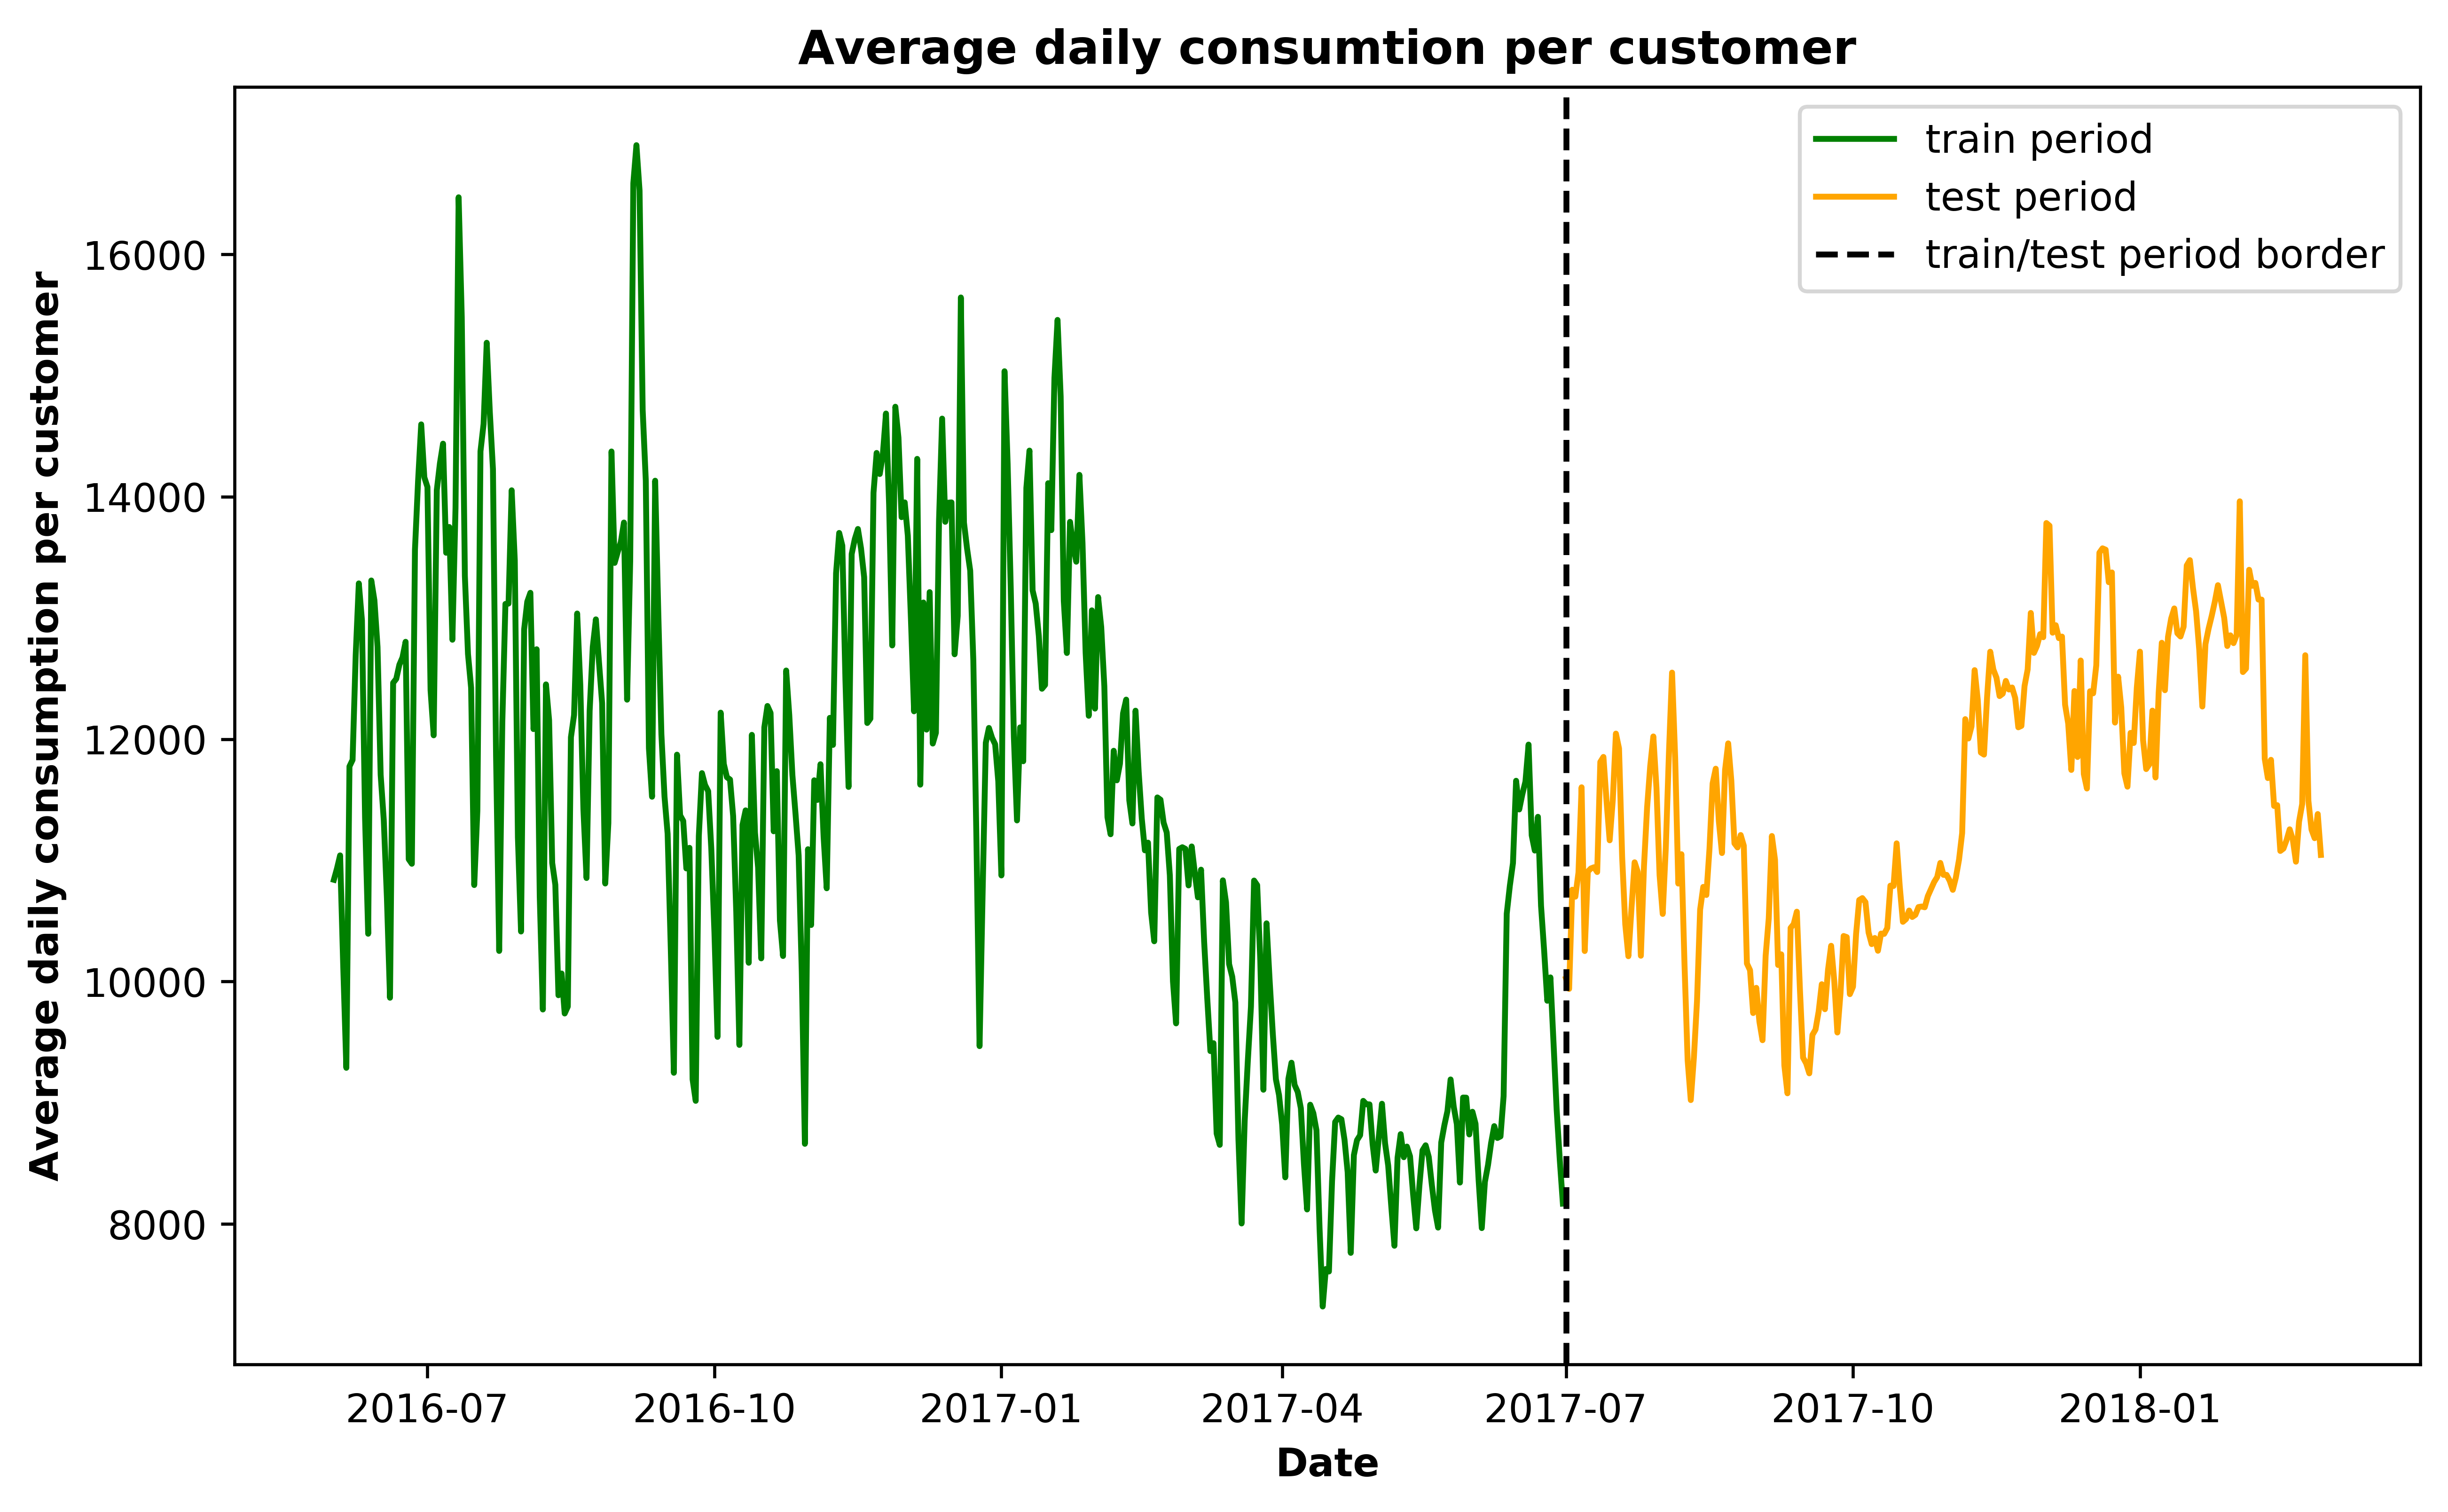

In [4]:
# Create a dataframe with single column - dates for the test period
test = temperatures2[['Date']]

# Add features from 3 other files
test = test.merge(sun_data, on = 'Date', how = 'left')
test = test.merge(temperatures, on = 'Date', how = 'left')
test = test.merge(ncustomers, on = 'Date', how = 'left')

# Prepare the matrix of features for test dataset
X_test = test[['tMean', 'Length', 'growth']]

# Predict average daily consumption per client for test period
test['AvgConsPerClient'] = cbr.predict(X_test)

display(test.head())

# Plot a chart to see how the model predicted average daily consumption per client for test period
# with respect to actual values from train period
fig2 = plt.figure(figsize = (10,6), dpi=300)
fig2ax1 = fig2.add_subplot(111)
fig2ax1.plot(train.Date, train.AvgConsPerClient, color = 'green', label = 'train period')
fig2ax1.plot(test.Date, test.AvgConsPerClient, color = 'orange', label = 'test period')
fig2ax1.set_xlabel('Date', weight = 'bold')
fig2ax1.set_ylabel('Average daily consumption per customer', weight = 'bold')
fig2ax1.set_title('Average daily consumtion per customer', weight = 'bold')
fig2ax1.axvline('2017-07-01', color = 'black', linestyle = 'dashed', label = 'train/test period border')
fig2ax1.legend()

plt.show()

### Step 2. Move from average consumption per client to total daily consumption

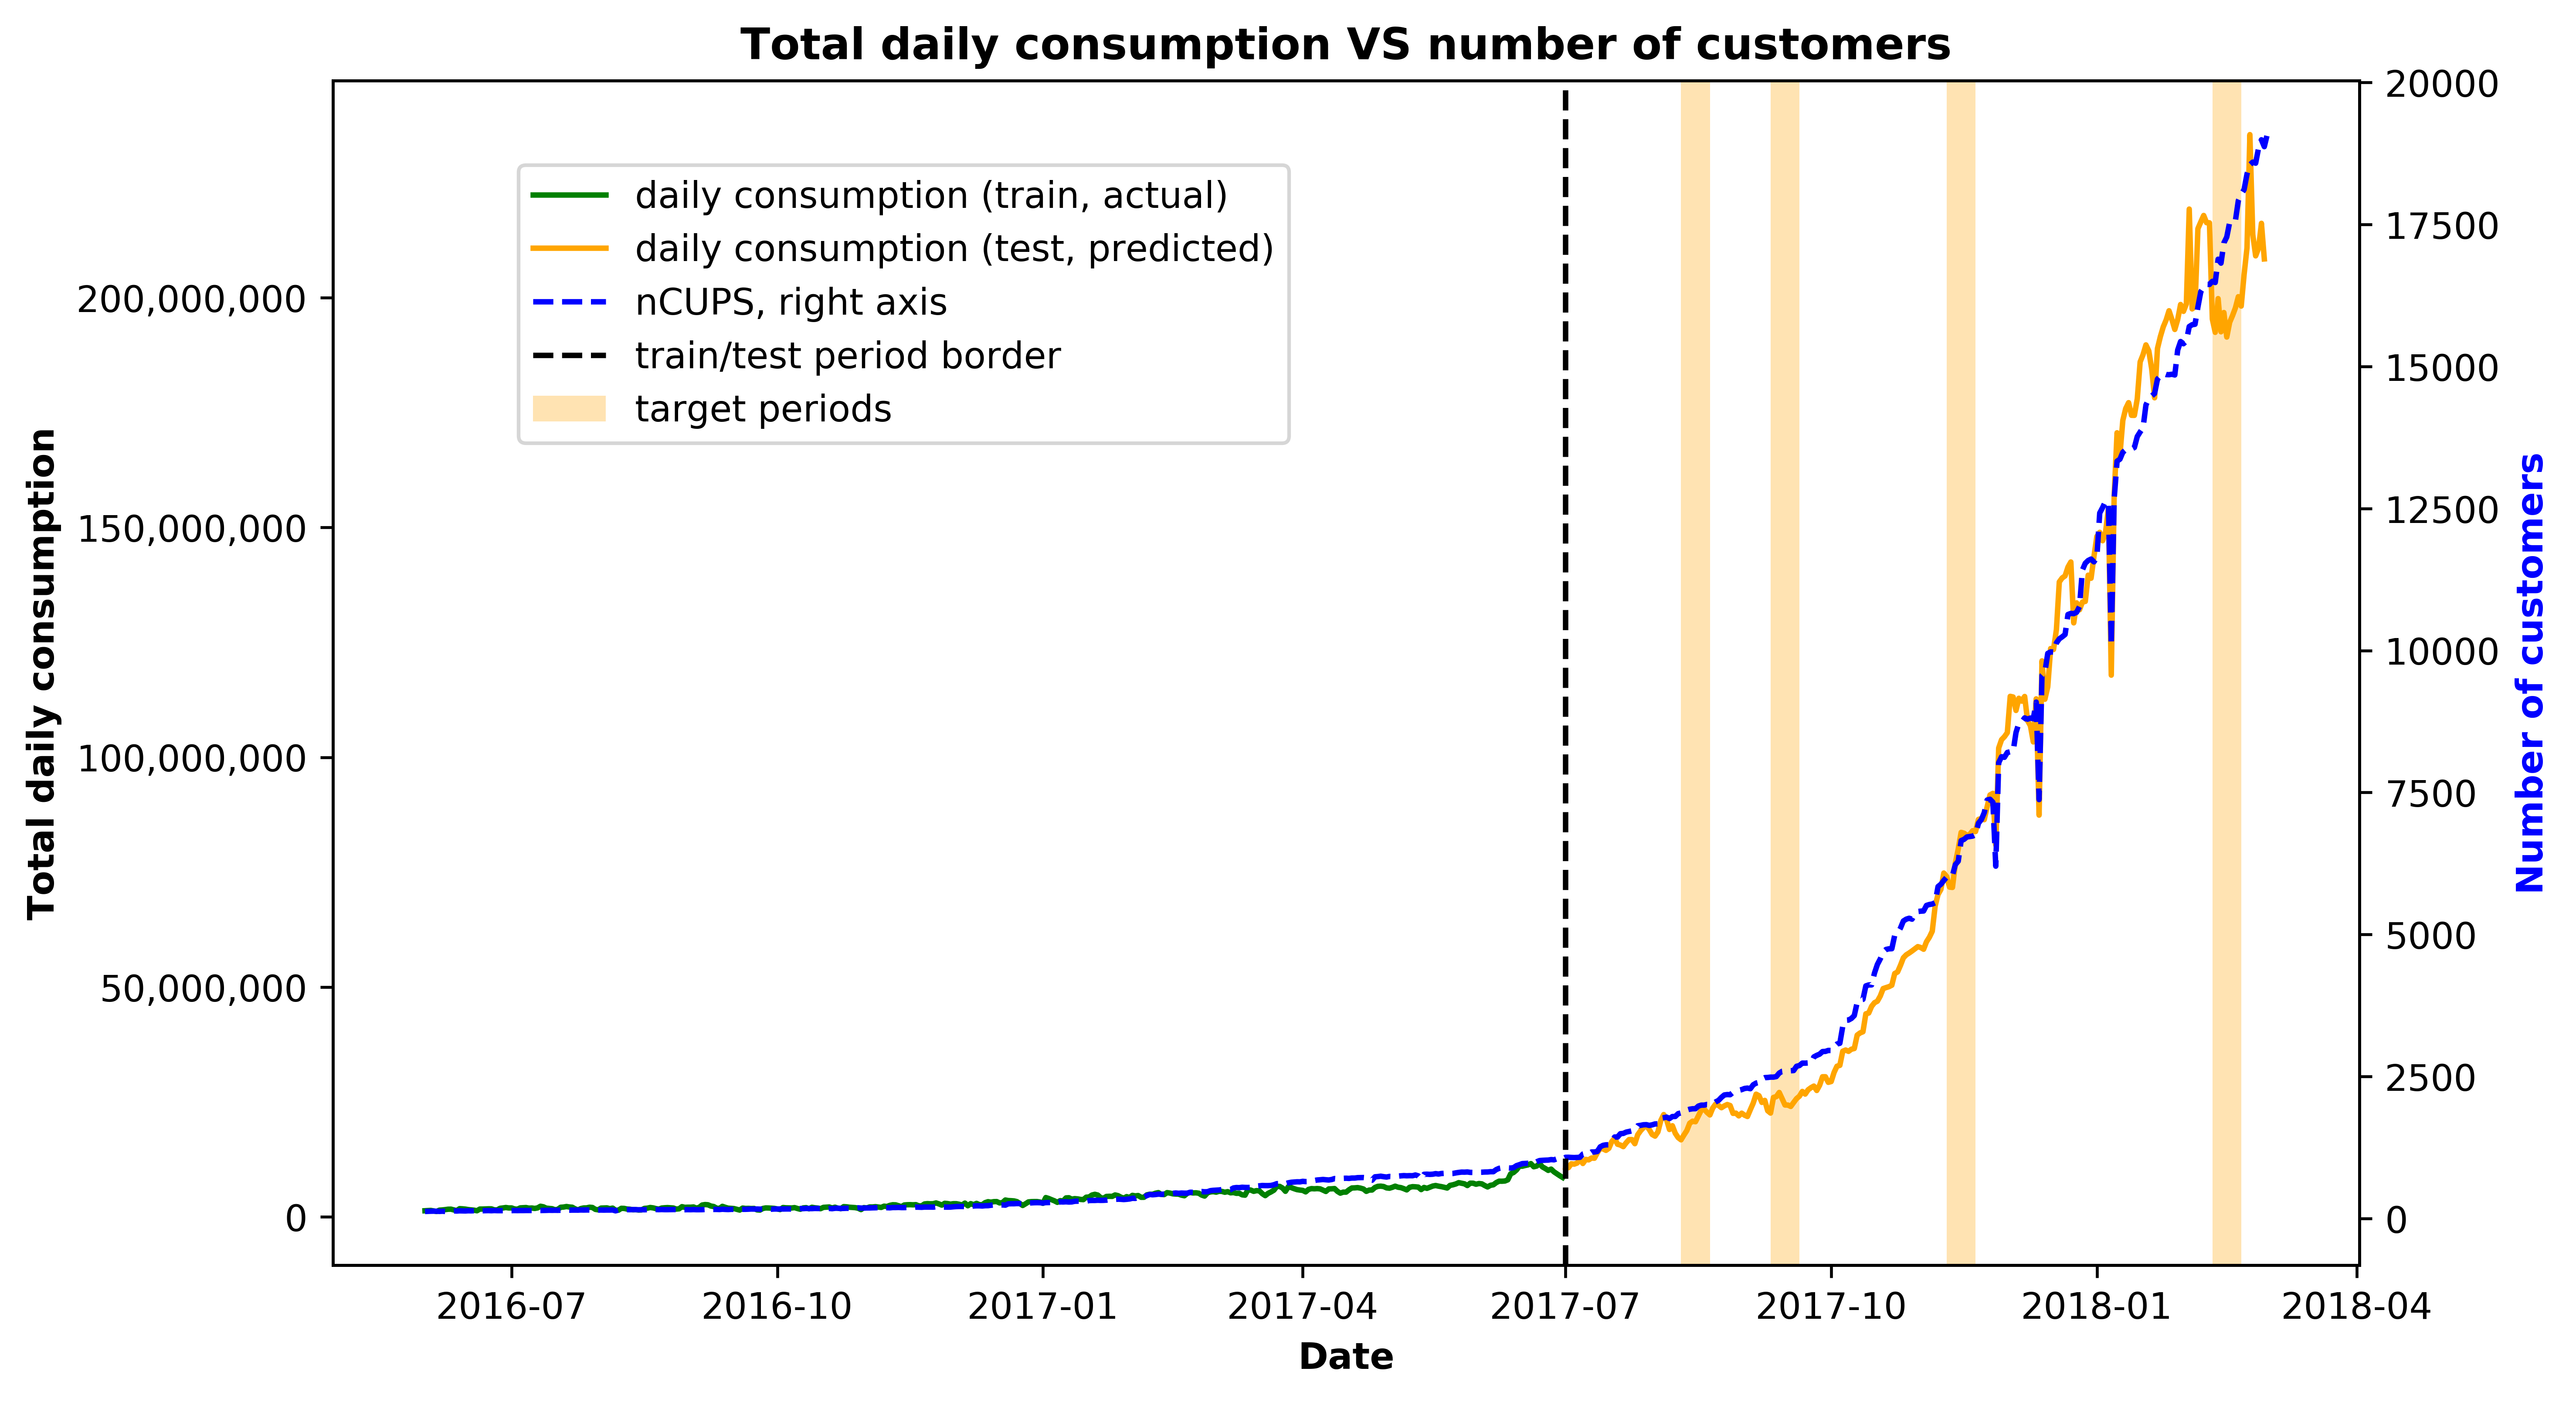

In [5]:
# Once the average daily consumption per client is predicted, and we know the number of clients,
# multiply those 2 to predict total daily consumption
test['dailyConsumption'] = test['nCUPS'] * test['AvgConsPerClient']

# Plot a figure to relate our total daily consumption predictions with number of customers.
fig3 = plt.figure(figsize = (10,6), dpi=300)
fig3ax1 = fig3.add_subplot(111)
fig3ax1.plot(train.Date, train.dailyConsumption, color = 'green', label = 'daily consumption (train, actual)')
fig3ax1.plot(test.Date, test.dailyConsumption, color = 'orange', label = 'daily consumption (test, predicted)')
fig3ax1.set_xlabel('Date', weight = 'bold')
fig3ax1.set_ylabel('Total daily consumption', weight = 'bold')
fig3ax1.set_title('Total daily consumption VS number of customers', weight = 'bold')
fig3ax1.ticklabel_format(axis = 'y', style='plain')
fig3ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

fig3ax2 = fig3ax1.twinx()
fig3ax2.plot(ncustomers.Date, ncustomers.nCUPS, color = 'blue', label = 'nCUPS, right axis', linestyle = 'dashed')
fig3ax2.axvspan('2017-08-10', '2017-08-20', facecolor='orange', alpha=0.3, label = 'target periods')
fig3ax2.axvspan('2017-09-10', '2017-09-20', facecolor='orange', alpha=0.3)
fig3ax2.axvspan('2017-11-10', '2017-11-20', facecolor='orange', alpha=0.3)
fig3ax2.axvspan('2018-02-10', '2018-02-20', facecolor='orange', alpha=0.3)
fig3ax2.axvline('2017-07-01', color = 'black', linestyle = 'dashed', label = 'train/test period border')
fig3ax2.set_ylabel('Number of customers', weight = 'bold', color = 'blue')

fig3.legend(bbox_to_anchor=(0.5, 0.8))

plt.show()

### Step 3.1. Estimate hourly distributions of daily consumpions for the train data

In [6]:
# Create 2 data frames from the train data - with daily and hourly consumption 
train_daily = consumptions[['Date', 'Value']].groupby(['Date'], \
              as_index=False).sum().sort_values(by=['Date'], ascending=True).rename(columns = {'Value':'dailyConsumption'})
train_hourly = consumptions[['Date', 'Hour', 'Value']].groupby(['Date', 'Hour'], \
              as_index=False).sum().sort_values(by=['Date', 'Hour'], ascending=True).rename(columns = {'Value':'hourlyConsumption'})

# Merge them properly
train_hourly = train_hourly.merge(train_daily, on = 'Date', how = 'left')

# For each hour of each day, calculate the fraction of this day's consumption attributed to this hour
train_hourly['fraction'] = train_hourly.hourlyConsumption / train_hourly.dailyConsumption

display(train_hourly)

,Date,Hour,hourlyConsumption,dailyConsumption,fraction
0,2016-06-01,1,46257,1344028,0.034417
1,2016-06-01,2,32488,1344028,0.024172
2,2016-06-01,3,28666,1344028,0.021328
3,2016-06-01,4,29334,1344028,0.021825
4,2016-06-01,5,27025,1344028,0.020107
...,...,...,...,...,...
9474,2017-06-30,20,377980,8583162,0.044037
9475,2017-06-30,21,388733,8583162,0.045290
9476,2017-06-30,22,419423,8583162,0.048866
9477,2017-06-30,23,427963,8583162,0.049861


### Step 3.2. Apply these hourly fractions to distribute predicted daily consumption by hours

In [7]:
# Create a data frame for test period - just dates and predicted daily consumption
test_daily_cons = test[['Date', 'dailyConsumption']]
print('Test file, v1: only dates and daily consumption')
display(test_daily_cons)

# The next goal is to convert this dataframe to hourly format.
# Create lists of all unique dates and hours for test set.
dates = test['Date'].tolist()
hours = np.arange(1,25)

# Initialize an empty dictionary
date_hour_dict = {'Date': [],
                  'Hour': []}

# Fill this dictionary with date-hour pairs
for date in dates:
    for hour in hours:
        date_hour_dict['Date'].append(date)
        date_hour_dict['Hour'].append(hour)

# Create a data frame from this dictionary, and properly merge it to daily consumption data
test_hourly_cons = pd.DataFrame(data = date_hour_dict)
test_hourly_cons = test_hourly_cons.merge(test_daily_cons, on = 'Date', how = 'left')

print(splitline)
print('Test file, v2: dates, hours, and daily consumption')
display(test_hourly_cons)

test_hourly_cons['Date1yAgo'] = test_hourly_cons['Date'] - pd.DateOffset(years = 1)

test_hourly_cons = test_hourly_cons.merge(train_hourly[['Date', 'Hour', 'fraction']],
                                          left_on = ['Date1yAgo', 'Hour'],
                                          right_on = ['Date', 'Hour'],
                                          how = 'left')

test_hourly_cons['hourlyConsumption'] = test_hourly_cons.dailyConsumption * test_hourly_cons.fraction
print(splitline)
print('Test file, v3: daily consumption is distributed by hours')
display(test_hourly_cons)

Test file, v1: only dates and daily consumption


,Date,dailyConsumption
0,2017-07-01,1.079476e+07
1,2017-07-02,1.071406e+07
2,2017-07-03,1.156399e+07
3,2017-07-04,1.148084e+07
4,2017-07-05,1.171636e+07
...,...,...
238,2018-02-24,2.137156e+08
239,2018-02-25,2.090819e+08
240,2018-02-26,2.107300e+08
241,2018-02-27,2.161556e+08


----------------------------------------------------------------------------------------------------
Test file, v2: dates, hours, and daily consumption


,Date,Hour,dailyConsumption
0,2017-07-01,1,1.079476e+07
1,2017-07-01,2,1.079476e+07
2,2017-07-01,3,1.079476e+07
3,2017-07-01,4,1.079476e+07
4,2017-07-01,5,1.079476e+07
...,...,...,...
5827,2018-02-28,20,2.084125e+08
5828,2018-02-28,21,2.084125e+08
5829,2018-02-28,22,2.084125e+08
5830,2018-02-28,23,2.084125e+08


----------------------------------------------------------------------------------------------------
Test file, v3: daily consumption is distributed by hours


,Date_x,Hour,dailyConsumption,Date1yAgo,Date_y,fraction,hourlyConsumption
0,2017-07-01,1,1.079476e+07,2016-07-01,2016-07-01,0.034860,3.763060e+05
1,2017-07-01,2,1.079476e+07,2016-07-01,2016-07-01,0.028747,3.103176e+05
2,2017-07-01,3,1.079476e+07,2016-07-01,2016-07-01,0.024535,2.648527e+05
3,2017-07-01,4,1.079476e+07,2016-07-01,2016-07-01,0.023535,2.540587e+05
4,2017-07-01,5,1.079476e+07,2016-07-01,2016-07-01,0.022883,2.470153e+05
...,...,...,...,...,...,...,...
5827,2018-02-28,20,2.084125e+08,2017-02-28,2017-02-28,0.053416,1.113266e+07
5828,2018-02-28,21,2.084125e+08,2017-02-28,2017-02-28,0.059094,1.231588e+07
5829,2018-02-28,22,2.084125e+08,2017-02-28,2017-02-28,0.059744,1.245136e+07
5830,2018-02-28,23,2.084125e+08,2017-02-28,2017-02-28,0.052734,1.099044e+07


### Final step. Prepare the solution file

In [8]:
# Drop all columns except those used in submission
test_hourly_cons.drop(['dailyConsumption', 'Date1yAgo', 'Date_y', 'fraction'], axis = 1, inplace = True)
# Rename the date column back - it was affected by 'merge' function
test_hourly_cons = test_hourly_cons.rename(columns = {'Date_x': 'Date'})

# Slice the test predictions so they include only the required intervals
solution = test_hourly_cons.loc[
                   ((test_hourly_cons.Date >= '2017-08-10') & (test_hourly_cons.Date <= '2017-08-20')) |
                   ((test_hourly_cons.Date >= '2017-09-10') & (test_hourly_cons.Date <= '2017-09-20')) |
                   ((test_hourly_cons.Date >= '2017-11-10') & (test_hourly_cons.Date <= '2017-11-20')) |
                   ((test_hourly_cons.Date >= '2018-02-10') & (test_hourly_cons.Date <= '2018-02-20'))
                   ]

display(solution)

# Call this function in the next cell to generate a .csv
def generate_solution():
    solution.to_csv('./fedotov_power.csv', header = False, index = False)

,Date,Hour,hourlyConsumption
960,2017-08-10,1,6.239022e+05
961,2017-08-10,2,5.181836e+05
962,2017-08-10,3,5.223062e+05
963,2017-08-10,4,4.773200e+05
964,2017-08-10,5,4.352617e+05
...,...,...,...
5635,2018-02-20,20,1.038982e+07
5636,2018-02-20,21,1.159090e+07
5637,2018-02-20,22,1.197423e+07
5638,2018-02-20,23,1.085407e+07


In [9]:
generate_solution()